In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
df = pd.read_csv("retentiondata_case.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (5636, 36)
Columns: ['acct_ref', 'cust_ref', 'has_dependents', 'tenure_mo', 'home_phone', 'multi_line', 'internet_plan', 'add_on_security', 'add_on_backup', 'add_on_protection', 'tech_support_std', 'stream_tv', 'stream_movies', 'contract_term', 'e_bill_opt_in', 'pay_method', 'monthly_fee', 'total_billed', 'left_flag', 'fiscal_qtr', 'gender', 'age_years', 'is_married', 'dependents_count', 'referred_friend', 'referrals_count', 'recent_offer', 'avg_long_dist_fee', 'internet_tech', 'avg_gb_download', 'premium_support', 'stream_music', 'unlimited_data_opt', 'refunds_total', 'extra_data_fees_total', 'long_dist_fees_total']


,acct_ref,cust_ref,has_dependents,tenure_mo,home_phone,multi_line,internet_plan,add_on_security,add_on_backup,add_on_protection,...,recent_offer,avg_long_dist_fee,internet_tech,avg_gb_download,premium_support,stream_music,unlimited_data_opt,refunds_total,extra_data_fees_total,long_dist_fees_total
0,ACCT137932,CUST61880322,No,1,No,No phone service,DSL,No,Yes,No,...,Offer E,0.00,DSL,10,No,No,Yes,0.0,0,0.00
1,ACCT115088,CUST55192304,No,34,Yes,No,DSL,Yes,No,Yes,...,NaN,17.09,DSL,16,No,No,Yes,0.0,0,581.06
2,ACCT623423,CUST16890051,No,2,Yes,No,DSL,Yes,Yes,No,...,NaN,10.47,DSL,21,No,No,Yes,0.0,0,20.94
3,ACCT846960,CUST99388728,No,45,No,No phone service,DSL,Yes,No,Yes,...,NaN,0.00,DSL,10,Yes,No,Yes,0.0,0,0.00
4,ACCT146586,CUST91125265,No,2,Yes,No,Fiber optic,No,No,No,...,NaN,9.12,Fiber Optic,51,No,No,Yes,0.0,0,18.24


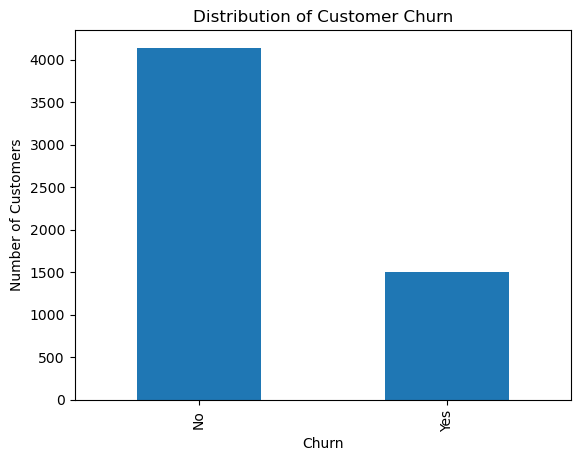

In [99]:
df['left_flag'].value_counts().plot(kind='bar')
plt.title("Distribution of Customer Churn")
plt.xlabel("Churn")
plt.ylabel("Number of Customers")
plt.show()

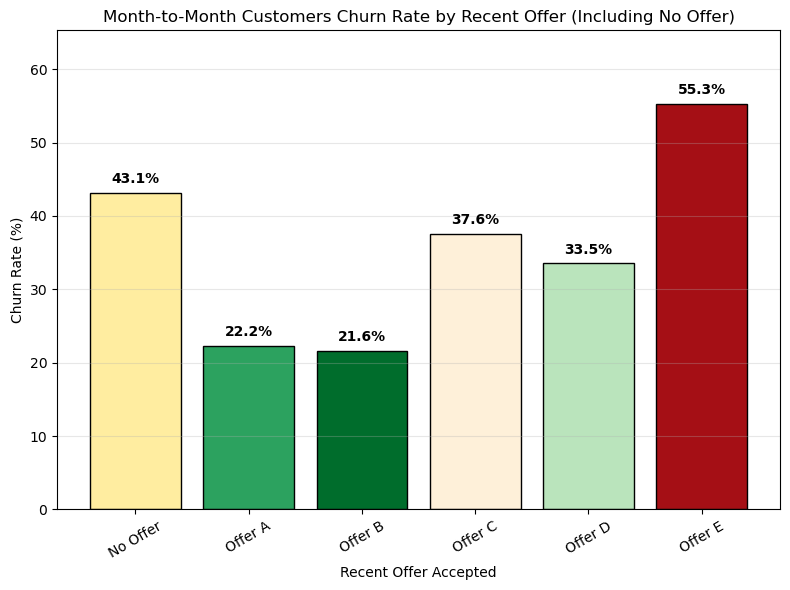

In [104]:



# Gérer les valeurs manquantes dans 'recent_offer'
df['recent_offer'] = df['recent_offer'].fillna('No Offer')

# Filtrer les clients "Month-to-month"
m2m_data = df[df['contract_term'] == 'Month-to-month']

# Calculer le taux de churn par offre
churn_rate = (
    m2m_data
    .groupby('recent_offer')['left_flag']
    .mean()
    .reset_index()
)

# Convertir en pourcentage
churn_rate['churn_pct'] = churn_rate['left_flag'] * 100

# --- 2. Configuration des couleurs personnalisées ---
# Utilisation d'un mapping manuel pour garantir des couleurs uniques et distinctes
custom_colors = {
    'No Offer': '#ffeda0', # Jaune clair (Orange clair de l'image)
    'Offer A': '#2ca25f',  # Vert foncé 
    'Offer B': '#006d2c',  # Un vert légèrement différent pour la distinction
    'Offer C': '#fef0d9',  # Crème
    'Offer D': '#bae4bc',  # Vert clair
    'Offer E': '#a50f15',  # Rouge foncé (Bourgogne)
}

# Assurez l'ordre d'affichage des barres
order = ['No Offer', 'Offer A', 'Offer B', 'Offer C', 'Offer D', 'Offer E']
churn_rate['recent_offer'] = pd.Categorical(churn_rate['recent_offer'], categories=order, ordered=True)
churn_rate = churn_rate.sort_values('recent_offer')

# Mapper les offres aux couleurs
mapped_colors = [custom_colors[offer] for offer in churn_rate['recent_offer']]

# --- 3. Tracé du graphique ---
plt.figure(figsize=(8,6))
bars = plt.bar(
    churn_rate['recent_offer'],
    churn_rate['churn_pct'],
    color=mapped_colors,
    edgecolor='black'
)

# --- 4. Mise en forme et étiquettes ---
# Ajout des étiquettes de données (valeurs de pourcentage)
plt.bar_label(bars, fmt='%.1f%%', padding=5, fontweight='bold')

plt.title('Month-to-Month Customers Churn Rate by Recent Offer (Including No Offer)')
plt.xlabel('Recent Offer Accepted')
plt.ylabel('Churn Rate (%)')
plt.xticks(rotation=30)
# Ajuste l'axe Y pour laisser de la place aux étiquettes
plt.ylim(0, churn_rate['churn_pct'].max() + 10) 
plt.grid(axis='y', alpha=0.3)
plt.tight_layout() # Assure que tout le texte rentre dans la figure

plt.show()



C:\Users\ngueg\AppData\Local\Temp\ipykernel_4388\3554640788.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['monthly_fee_band','pay_method'])['left_flag']


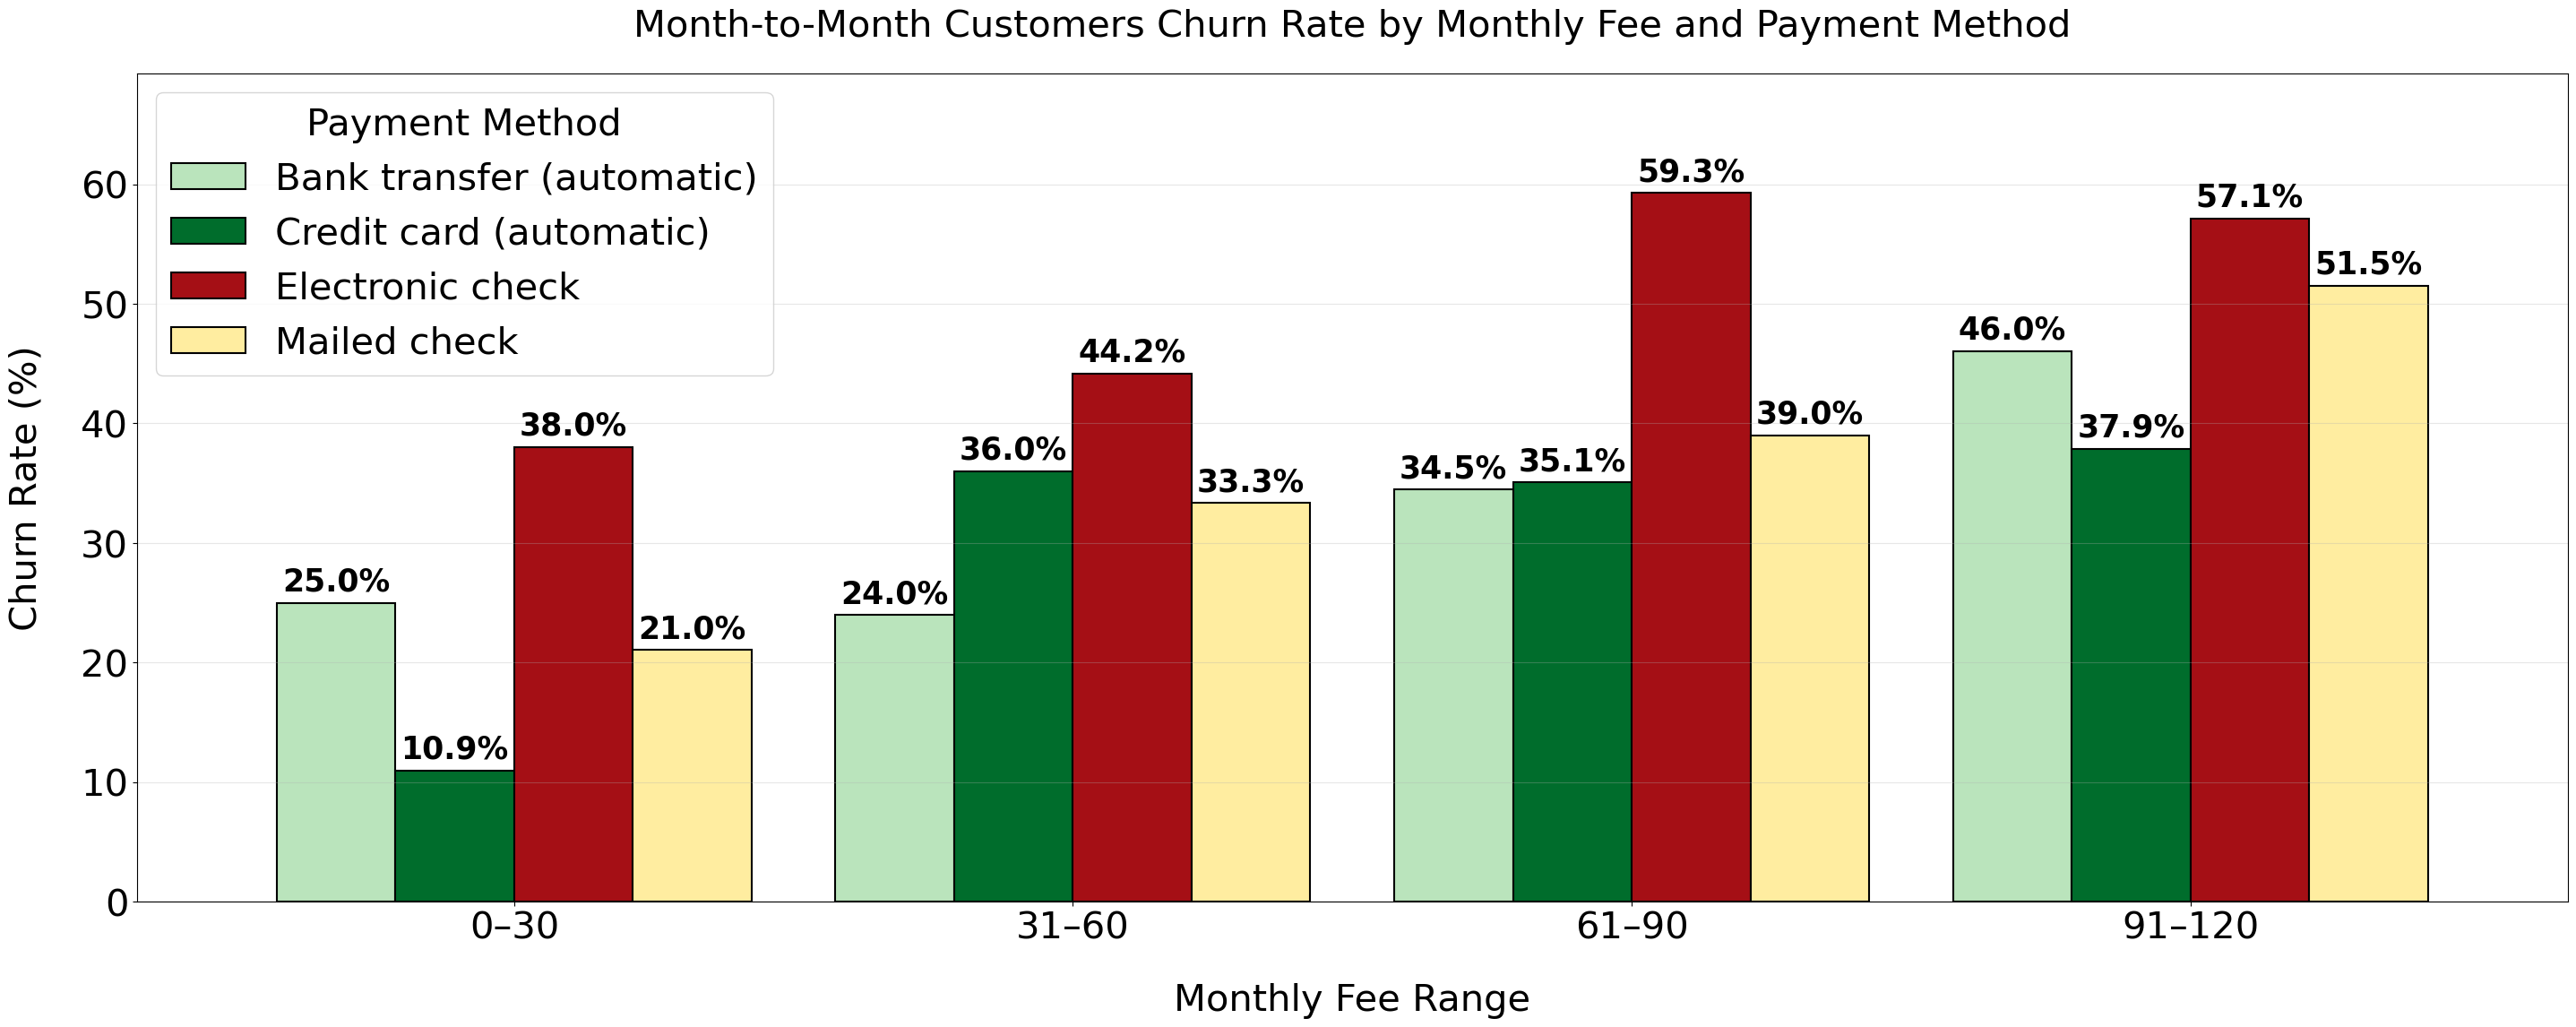

In [108]:
m2m_data = df[df['contract_term'] == 'Month-to-month'].copy()

# Step 3: Create monthly fee bands
bins = [0, 30, 60, 90, 120]
labels = ['0–30', '31–60', '61–90', '91–120']
m2m_data['monthly_fee_band'] = pd.cut(
    pd.to_numeric(m2m_data['monthly_fee'], errors='coerce'),
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Step 4: Pivot table so pay_method are columns
churn_table = (
    m2m_data
    .groupby(['monthly_fee_band','pay_method'])['left_flag']
    .mean()
    .unstack()
)

# Fill missing values with 0 and convert to percentage
churn_table = churn_table.fillna(0) * 100
ax = churn_table.plot(
    kind='bar',
    figsize=(35,12),
    edgecolor='black',          # black edges
    linewidth=1.5,  # slightly thicker for clarity
    width=0.85, 
    color=['#bae4bc','#006d2c','#a50f15','#ffeda0']  # blue, sky green, light red, orange
)

for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v:.1f}%" for v in container.datavalues],
        padding=5,
        fontsize=25,
        fontweight='bold'
    )

plt.title("Month-to-Month Customers Churn Rate by Monthly Fee and Payment Method", fontsize=30, pad=30)
plt.xlabel("Monthly Fee Range", fontsize=30, labelpad=29)
plt.ylabel("Churn Rate (%)", fontsize=30, labelpad=29)
plt.xticks(rotation=0, fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(0, churn_table.values.max() + 10)
plt.legend(title="Payment Method", fontsize=30, title_fontsize=30)
plt.grid(axis='y', alpha=0.3)
plt.show()

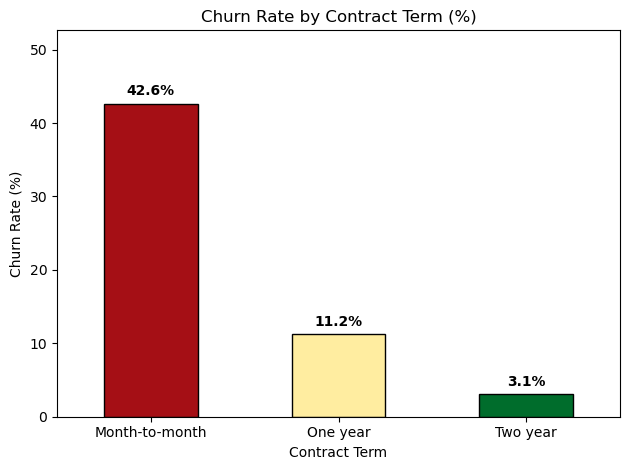

In [113]:

churn_by_contract = (df.groupby('contract_term')['left_flag'].mean().sort_index()) * 100

# 2. Define your colors
colors_list = ['#a50f15', '#ffeda0', '#006d2c']

# 3. Create the plot
ax = churn_by_contract.plot(
    kind='bar', 
    edgecolor='black',
    color=colors_list 
)

# 4. Add the labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=10,
                fontweight='bold')

# 5. Final formatting
plt.title("Churn Rate by Contract Term (%)")
plt.xlabel("Contract Term")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, churn_by_contract.max() + 10) # Adds space at the top for labels
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

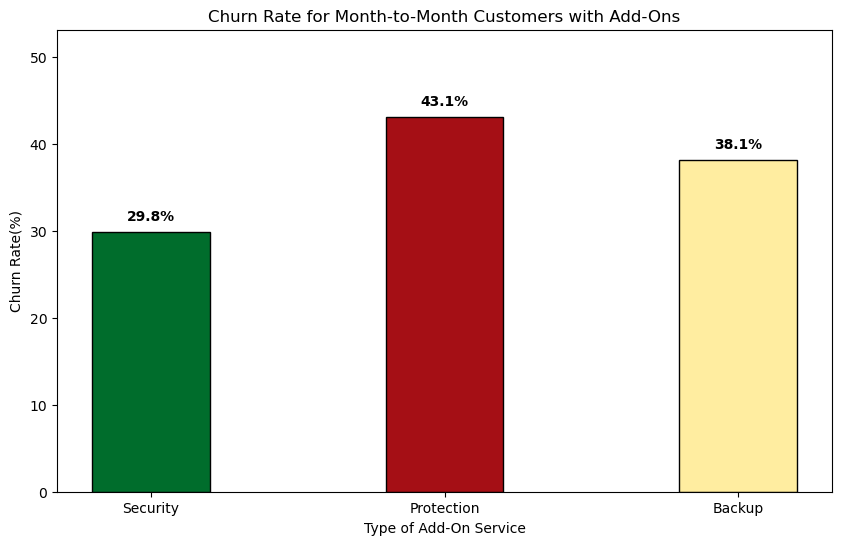

In [129]:
m2m_df = df[df['contract_term'] == 'Month-to-month']

# 2. Calculate churn rate for each add-on (multiply by 100 for whole numbers)
# We calculate the mean for each column where the value is 'Yes'
add_on_churn = {
    'Security': m2m_df[m2m_df['add_on_security'] == 'Yes']['left_flag'].mean() * 100,
    'Protection': m2m_df[m2m_df['add_on_protection'] == 'Yes']['left_flag'].mean() * 100,
    'Backup': m2m_df[m2m_df['add_on_backup'] == 'Yes']['left_flag'].mean() * 100
}

# 3. Create the bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(add_on_churn.keys(), add_on_churn.values(), color=['#006d2c', '#a50f15', '#ffeda0'], edgecolor='black', 
    width=0.4 )

# 4. Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontweight='bold')

# 5. Final touches
plt.title("Churn Rate for Month-to-Month Customers with Add-Ons")
plt.xlabel("Type of Add-On Service")
plt.ylabel("Churn Rate(%)")
plt.ylim(0, max(add_on_churn.values()) + 10) # Space for labels
plt.show()

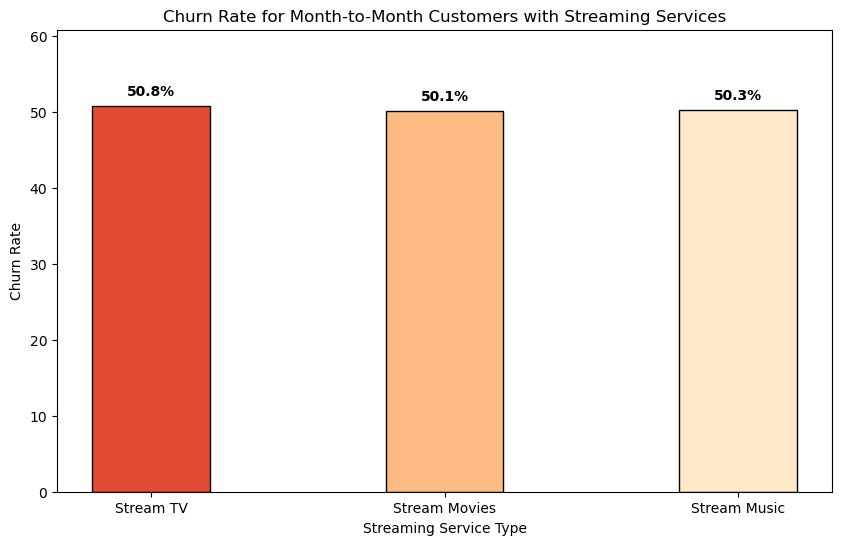

In [127]:
m2m_df = df[df['contract_term'] == 'Month-to-month']

# 2. Calculate churn rate for each streaming service (multiplied by 100 for whole numbers)
streaming_churn = {
    'Stream TV': m2m_df[m2m_df['stream_tv'] == 'Yes']['left_flag'].mean() * 100,
    'Stream Movies': m2m_df[m2m_df['stream_movies'] == 'Yes']['left_flag'].mean() * 100,
    'Stream Music': m2m_df[m2m_df['stream_music'] == 'Yes']['left_flag'].mean() * 100
}

# 3. Create the bar graph
plt.figure(figsize=(10, 6))
colors = ['#e34a33', '#fdbb84', '#fee8c8'] # Using a warm palette for streaming
bars = plt.bar(streaming_churn.keys(), streaming_churn.values(), color=colors, edgecolor='black', 
    width=0.4 )

# 4. Add labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# 5. Final touches
plt.title("Churn Rate for Month-to-Month Customers with Streaming Services")
plt.xlabel("Streaming Service Type")
plt.ylabel("Churn Rate")
plt.ylim(0, max(streaming_churn.values()) + 10) 
plt.show()

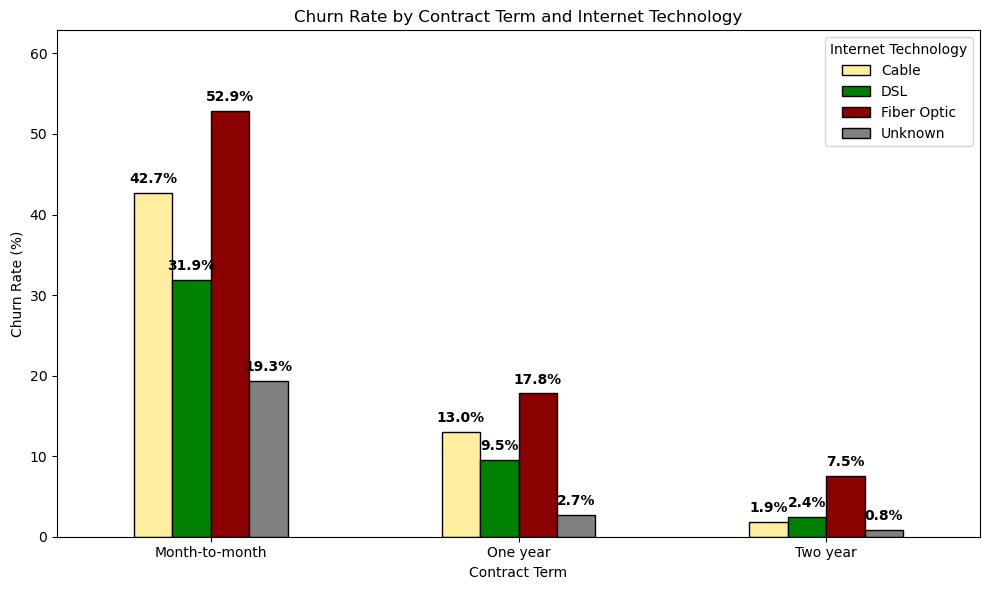

In [159]:

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fill missing internet_tech as 'Unknown'
df['internet_tech_filled'] = df['internet_tech'].fillna('Unknown')

# Step 2: Calculate churn rate by contract_term and internet_tech
churn_table = df.groupby(['contract_term', 'internet_tech_filled'])['left_flag'].mean().unstack(fill_value=0)

# Step 3: Convert to percentages
churn_table_pct = churn_table * 100

# Step 4: Define colors including Unknown
tech_colors = {
    'Cable': '#ffeda0',
    'DSL': 'green',
    'Fiber Optic': 'darkred',
    'Unknown': 'gray'
}

column_order = ['Cable', 'DSL', 'Fiber Optic', 'Unknown']

# Step 5: Plot grouped bar chart
ax = churn_table_pct[column_order].plot(
    kind='bar',
    figsize=(10,6),
    edgecolor='black',
    color=[tech_colors[col] for col in column_order]
)

# Step 6: Add value labels on bars
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f"{v:.1f}%" for v in container.datavalues],
        padding=5,
        fontweight='bold'
    )

# Step 7: Format chart
plt.title("Churn Rate by Contract Term and Internet Technology")
plt.xlabel("Contract Term")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, churn_table_pct.max().max() + 10)
plt.xticks(rotation=0)
plt.legend(title="Internet Technology")
plt.tight_layout()
plt.show()